In [51]:
## Installing fasttext package if needed
!pip -q install -U fasttext seaborn gensim scikit-learn numpy pandas

#https://radimrehurek.com/gensim/models/fasttext.html
#https://colab.research.google.com/drive/1_jZOV8G-zr11aHYcgV9IFpCgObA4Br1E#scrollTo=62Ui7K--RZry
#https://www.kaggle.com/pierremegret/gensim-word2vec-tutorial

In [52]:
import os
import sys
import re
import pickle
import json

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from gensim.models.fasttext import FastText
from gensim.models import Word2Vec

import fasttext
import fasttext.util

from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

import parser

### Retrieving pickle

In [2]:
df_files = pd.read_pickle('../outputs/df_files.pkl')

In [4]:
folder = '/home/jovyan/shared/C_amc_141/R_amc_3.1_12921/203_vert_spacy_rftt/'

In [33]:
for filepath in df_files[0:1].path:
    path = os.path.join(folder, filepath)
    response = parser.parse(path)
    response = list(response)

In [34]:
# Defining values for parameters
embedding_size = 300
window_size = 5
min_word = 3
down_sampling = 1e-2


model = FastText(response,
                 size=embedding_size,
                 window=window_size,
                 min_count=min_word,
                 sample=down_sampling,
                 workers = -1,
                 sg=1,
                 iter=100)

In [35]:
# Save fastText gensim model
model.save("./amc.model")

In [36]:
# Load saved gensim fastText model
model = Word2Vec.load("./amc.model")

In [37]:
model.wv.most_similar("Heute", topn=10)

[('heute', 0.38442522287368774),
 ('bedeute', 0.2580488920211792),
 ('Bergleute', 0.2148878276348114),
 ('erreicht', 0.20485587418079376),
 ('österreichischen', 0.19959671795368195),
 ('Österreichischen', 0.18770058453083038),
 ('31.', 0.18277209997177124),
 ('reichte', 0.18252317607402802),
 ('reichischen', 0.18193921446800232),
 ('ernannt.', 0.18182086944580078)]

In [38]:
for filepath in df_files[1:2].path:
    path = os.path.join(folder, filepath)
    response = parser.parse(path)
    response = list(response)

In [39]:
model.build_vocab(response, update=True)  # Update the vocabulary
model.train(response, total_examples=len(response), epochs=model.epochs)

In [40]:
model.wv.most_similar("Heute", topn=10)

[('heute', 0.38442522287368774),
 ('bedeute', 0.2580488920211792),
 ('Bergleute', 0.2148878276348114),
 ('erreicht', 0.20485587418079376),
 ('österreichischen', 0.19959671795368195),
 ('Österreichischen', 0.18770058453083038),
 ('31.', 0.18277209997177124),
 ('reichte', 0.18252317607402802),
 ('reichischen', 0.18193921446800232),
 ('ernannt.', 0.18182086944580078)]

In [41]:
for filepath in df_files[2:3].path:
    path = os.path.join(folder, filepath)
    response = parser.parse(path)
    response = list(response)

In [42]:
model.build_vocab(response, update=True)  # Update the vocabulary
model.train(response, total_examples=len(response), epochs=model.epochs)

In [43]:
model.wv.most_similar("Heute", topn=10)

[('heute', 0.38442522287368774),
 ('bedeute', 0.2580488920211792),
 ('Bergleute', 0.2148878276348114),
 ('erreicht', 0.20485587418079376),
 ('Piste', 0.20303618907928467),
 ('österreichischen', 0.19959671795368195),
 ('Österreichischen', 0.18770058453083038),
 ('Leute,', 0.18441756069660187),
 ('31.', 0.18277209997177124),
 ('reichte', 0.18252317607402802)]

In [44]:
def tsne_plot(for_word, w2v_model):
    # trained fastText model dimention
    dim_size = w2v_model.wv.vectors.shape[1]
    arrays = np.empty((0, dim_size), dtype='f')
    word_labels = [for_word]
    color_list  = ['red']
    # adds the vector of the query word
    arrays = np.append(arrays, w2v_model.wv.__getitem__([for_word]), axis=0)
    # gets list of most similar words
    sim_words = w2v_model.wv.most_similar(for_word, topn=10)
    # adds the vector for each of the closest words to the array
    for wrd_score in sim_words:
        wrd_vector = w2v_model.wv.__getitem__([wrd_score[0]])
        word_labels.append(wrd_score[0])
        color_list.append('green')
        arrays = np.append(arrays, wrd_vector, axis=0)
    #---------------------- Apply PCA and tsne to reduce dimention --------------
    # fit 2d PCA model to the similar word vectors
    model_pca = PCA(n_components = 10).fit_transform(arrays)
    # Finds 2d coordinates t-SNE
    np.set_printoptions(suppress=True)
    Y = TSNE(n_components=2, random_state=0, perplexity=15).fit_transform(model_pca)
    # Sets everything up to plot
    df_plot = pd.DataFrame({'x': [x for x in Y[:, 0]],
                            'y': [y for y in Y[:, 1]],
                            'words_name': word_labels,
                            'words_color': color_list})
    #------------------------- tsne plot Python -----------------------------------
    # plot dots with color and position
    fig, ax = plt.subplots(figsize=(16,10))
    plot_dot = sns.regplot(data=df_plot,
                           x="x",
                           y="y",
                           fit_reg=False,
                           marker="o",
                           ax=ax,
                           scatter_kws={'s': 40,
                                        'facecolors': df_plot['words_color']
                                        }
                           )
 
    # Adds annotations with color one by one with a loop
    for line in range(0, df_plot.shape[0]):
         plot_dot.text(df_plot["x"][line],
                 df_plot['y'][line],
                 '  ' + df_plot["words_name"][line].title(),
                 horizontalalignment='left',
                 verticalalignment='bottom', size='medium',
                 color=df_plot['words_color'][line],
                 weight='normal'
                ).set_size(15)
 
    plt.xlim(Y[:, 0].min()-50, Y[:, 0].max()+50)
    plt.ylim(Y[:, 1].min()-50, Y[:, 1].max()+50)
    plt.title('t-SNE visualization for word "{}'.format(for_word.title()) +'"')

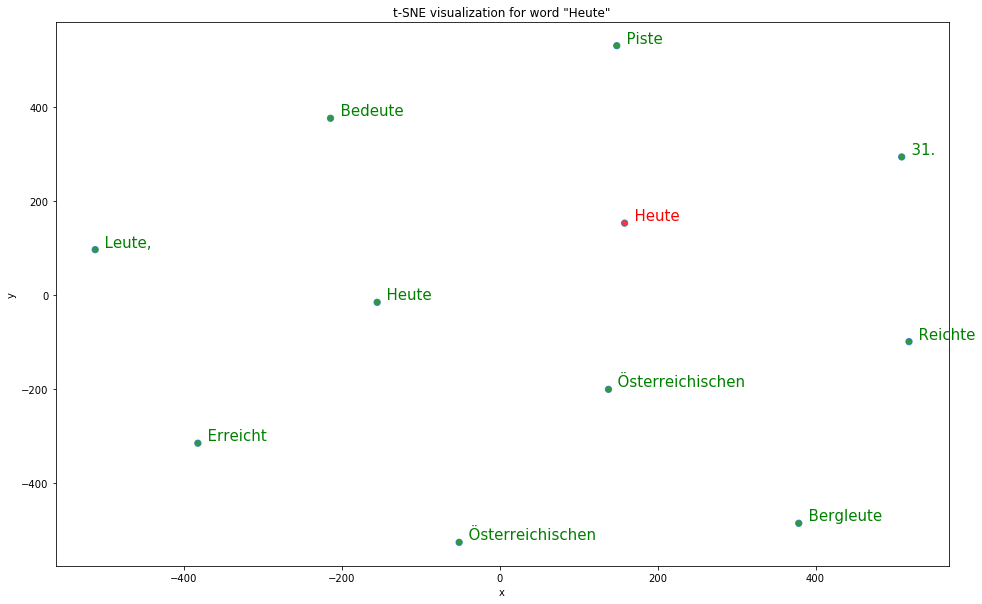

In [49]:
# tsne plot for top 10 similar word to 'chicken'
tsne_plot(for_word="Heute", w2v_model=model)